In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product

/opt/miniconda3/envs/symb_xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualization Code

In [3]:
from visualizations_utils import rescale_score_by_abs, getRGB, span_word, html_heatmap, \
make_text_string, make_color, vis_tree_heat


## LRP Modules

In [4]:
# from base_models import stabilize, modified_layer, ModifiedLinear, ModifiedLayerNorm, ModifiedAct, ModifiedTanh
# from explanation import gamma


## LRP for BERT

In [5]:
# from models import ModifiedBertAttention, ModifiedBertSelfOutput, ModifiedBertAttention,  \
# ModifiedBertIntermediate, ModifiedBertOutput, ModifiedBertLayer, ModifiedBertLayerHigherOrder, \
# ModifiedBertEncoder, ModifiedBertPooler, ModifiedBertModel, ModifiedBertForSequenceClassification


## XAI Utils

In [6]:
from explanation import symb_xai, lrp, HOExplainer

## BERT model with 3 layers

In [7]:
params = torch.load('sst2-3layer-model.pt', map_location=torch.device('cpu'))

model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")
model.bert.encoder.layer = model.bert.encoder.layer[:3]

model.bert.encoder.layer[0].intermediate = torch.nn.Identity()
model.bert.encoder.layer[1].intermediate = torch.nn.Identity()
model.bert.encoder.layer[2].intermediate = torch.nn.Identity()

model.bert.encoder.layer[0].output = torch.nn.Identity()
model.bert.encoder.layer[1].output = torch.nn.Identity()
model.bert.encoder.layer[2].output = torch.nn.Identity()

state_dict = model.state_dict()   

for i in range(3):
    state_dict['bert.encoder.layer.{}.attention.self.query.weight'.format(i)] = params['attention_layers.{}.query.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.weight'.format(i)] = params['attention_layers.{}.key.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.weight'.format(i)] = params['attention_layers.{}.value.weight'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.self.query.bias'.format(i)] = params['attention_layers.{}.query.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.key.bias'.format(i)] = params['attention_layers.{}.key.bias'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.self.value.bias'.format(i)] = params['attention_layers.{}.value.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.dense.weight'.format(i)] = params['attention_layers.{}.output.dense.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.dense.bias'.format(i)] = params['attention_layers.{}.output.dense.bias'.format(i)]
    
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.weight'.format(i)] = params['attention_layers.{}.output.LayerNorm.weight'.format(i)]
    state_dict['bert.encoder.layer.{}.attention.output.LayerNorm.bias'.format(i)] = params['attention_layers.{}.output.LayerNorm.bias'.format(i)]
    
    state_dict['bert.pooler.dense.weight'] = params['pooler.dense.weight']
    state_dict['bert.pooler.dense.bias'] = params['pooler.dense.bias']
    
    state_dict['classifier.weight'] = params['classifier.weight']
    state_dict['classifier.bias'] = params['classifier.bias']

In [8]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Explain tiny BERT model on the SST2 dataset

In [9]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    words = list(dataset.vocab.keys())


In [27]:
sid = 30
go = False

if mode == 'huggingface':
    sentence = dataset['validation']['sentence'][sid]
    label = dataset['validation']['label'][sid]
    
#     target = torch.nn.functional.one_hot(
#                 torch.tensor(label), num_classes=2)

elif mode == 'treebank':
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
    adj= tree.adj()
    
    lsent = [ words[idw] for idw in input_ids[mask == 1]]
    sentence = make_text_string(lsent)
    
    label = labels[0] 
        
target = torch.tensor([-1,1])

print(sentence)

explainer = HOExplainer(model)
explainer.setup_sample(sentence,target)
print('nb_tokens:', len(explainer.words), explainer.words)
if go: rels = explainer.explain()


it's been done before but never so vividly or with so much passion.
nb_tokens: 19 ['[CLS]', 'it', "'", 's', 'been', 'done', 'before', 'but', 'never', 'so', 'vivid', '##ly', 'or', 'with', 'so', 'much', 'passion', '.', '[SEP]']


In [12]:
sum([ rel for _, rel in rels.items()])

-1.172550136211612

In [13]:
# find more interesting sentences 
# check how the gt in the dataset where generated and adapt the evaluation for it

# new dataset movie review

In [14]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from xai_utils import make_color


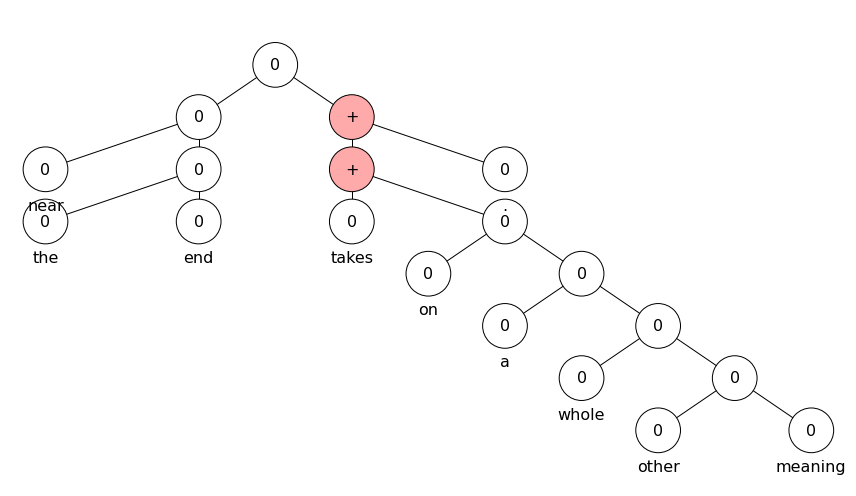

In [19]:
# plot ground truth
label2sent_symb = {0:'--', 1: '-', 2:'0', 3: '+', 4:'++'}

node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

vis_tree_heat(tree, node_heat, words, node_labels=node_labels, save_dir=f'pics/sample{sid}_ground_truth.png')


/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_3704/956109767.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


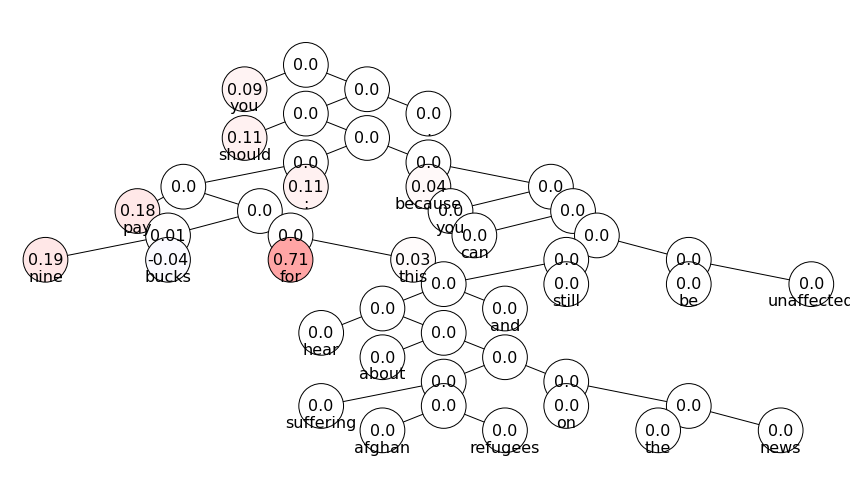

In [383]:
# plot relevance
def process_treeid2tokenid(indices, mask, tokens=None, lsent=None):
    treeInd2token = { int(treei) : tokeni+1 for tokeni, treei in enumerate(mask.nonzero().squeeze())}
    token_indices = set([ treeInd2token[ind] for ind in indices 
                         if ind in mask.nonzero().squeeze() ]) 
    
    return token_indices

mode ='and'

G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, add_cls=True)
    
    node_rels[node_id] = symb_xai(rels, token_set, mode=mode)
#     node_labels[node_id] = [explainer.words[token] for token in token_set]
    
node_heat = [make_color( rel, scaling=.5) for rel in node_rels.values() ]
# node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }
node_labels = {i:round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, node_heat, node_labels=node_labels, save_dir=f'pics/sample{sid}_contr_{mode}.png')
# print(node_rels)

/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_3704/956109767.py:12: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


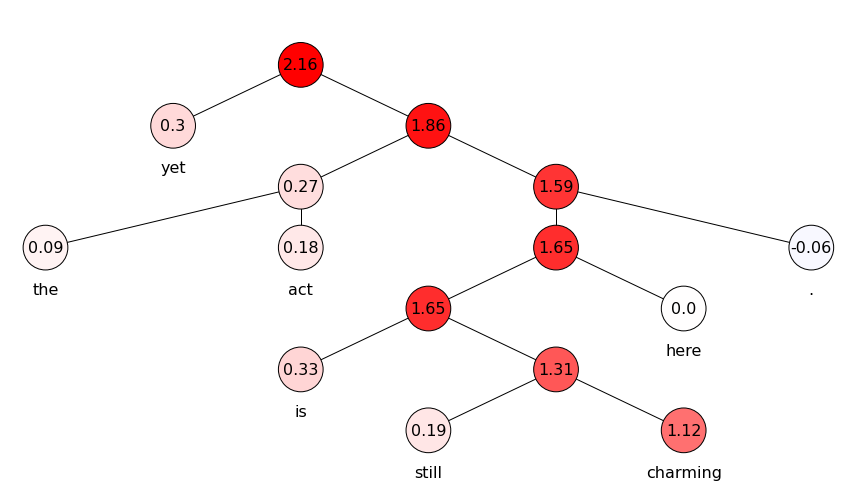

In [369]:
# first order XAI
G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

token_rel = {}
for tid in range(len(explainer.words)):
    token_rel[tid] = 0.
    for w, rel in rels.items():
        if w[0] == tid:
            token_rel[tid] += rel

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, add_cls=False)
    
    node_rels[node_id] = sum([token_rel[tid] for tid in token_set])

node_heat = [make_color( rel, scaling=.5) for rel in node_rels.values() ]

node_labels = {i: round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, node_heat, node_labels=node_labels, save_dir=f'pics/sample{sid}_contr_1order.png')

In [340]:

def comp_tree_node_rels(rels, tree, mode):
    node_rels = []
    G = dgl.to_networkx(tree)
    mask = mask = tree.ndata['mask']
    
    for node_id in range(len(mask)):
        ances = nx.ancestors(G, node_id)
        ances.add(node_id)

        if mode in ['subset', 'or']:
            token_set = process_treeid2tokenid(ances, mask)
            node_rels.append(symb_xai(rels, token_set, mode=mode))
            
        if mode == '1od':
            token_rel = {}
            token_set = process_treeid2tokenid(ances, mask)

            for tid in range(len(explainer.words)):
                token_rel[tid] = 0.
                for w, rel in rels.items():
                    if w[0] == tid:
                        token_rel[tid] += rel

            node_rels.append(sum([token_rel[tid] for tid in token_set]))

    return node_rels

nb_tokens: 10 nb_words: 8
yet the act is still charming here.
nb_tokens: 9 nb_words: 7
dramas like this make it human.
nb_tokens: 12 nb_words: 10
near the end takes on a whole other meaning.
nb_tokens: 7 nb_words: 5
the actors are fantastic.
nb_tokens: 14 nb_words: 12
they are what makes it worth the trip to the theatre.
nb_tokens: 12 nb_words: 10
some movies blend together as they become distant memories.
nb_tokens: 13 nb_words: 11
this comic gem is as delightful as it is derivative.
nb_tokens: 8 nb_words: 6
steven spielberg brings us another masterpiece
nb_tokens: 6 nb_words: 4
i will be.


ValueError: x and y must be the same size

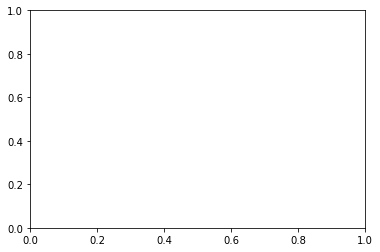

In [339]:
# compute correlation
all_rels = {}
for sid in range(100):
    go = False
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask'] # 1 if the node is a leaf, otherwise 0
    # adj= tree.adj()

    lsent = [ words[idw] for idw in input_ids[mask == 1]]
    sentence = make_text_string(lsent)

    label = labels[0] 

    target = torch.tensor([-1,1])

    explainer = HOExplainer(model)
    explainer.setup_sample(sentence,target)
    
    if len(explainer.words) -2 == len(lsent) and len(lsent) < 15: 
        print('nb_tokens:', len(explainer.words), 'nb_words:', len(lsent))
        print(sentence)
        go = True
#     if go: 
        rels = explainer.explain()
        all_rels[sid] = rels
        go = False




or 0.699


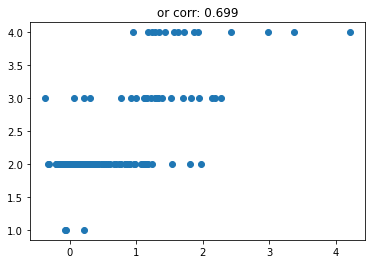

subset 0.506


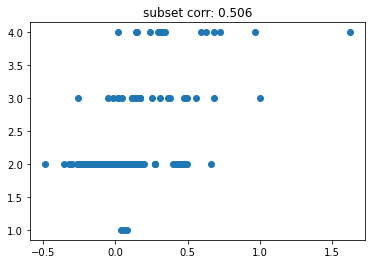

1od 0.695


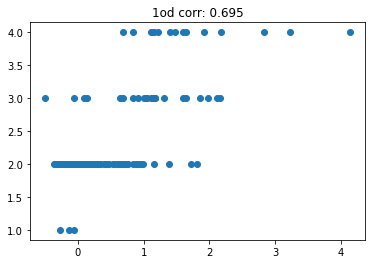

In [356]:
for mode in ['or', 'subset', '1od']:
    node_heat_gt = []
    node_rels = []
    for sid, rels in all_rels.items():
        tree = tree = dataset[sid]
        labels = tree.ndata['y']
        node_heat_gt += [float(label) for label in labels]
        node_rels += comp_tree_node_rels(rels, tree, mode)

    plt.scatter(node_rels, node_heat_gt)
    corr = round(np.corrcoef(node_rels, y=node_heat_gt)[0,1], 3)
    print(mode, corr)
    plt.title(mode + f' corr: {corr}')
    plt.show()

In [24]:
from xai_utils import create_text_heat_map
print("------------------")
print("Effect of feature 'bleak':")
R = np.zeros(len(words))
R_6 = symb_xai(rels, (6,), mode='and')
R[6] = R_6
print('rel', R_6)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Effect of feature 'desperate':")
R = np.zeros(len(words))
R_8 = symb_xai(rels, (8,), mode='and')
R[8] = R_8
print('rel', R_8)
display(HTML(create_text_heat_map(words, R.squeeze())))

print("------------------")
print("Joint effect of features 'bleak' and 'desperate':")
R = np.zeros(len(words))
R_68 = symb_xai(rels, (6, 8), mode='and')
R[6] = R_68
R[8] = R_68
print('rel', R_68)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

print("------------------")
print("Joint effect of features 'bleak', 'and', and 'desperate':")
R = np.zeros(len(words))
R_678 = symb_xai(rels, (6, 7, 8), mode='and')
R[6] = R_678
R[7] = R_678
R[8] = R_678
print('rel', R_678)
display(HTML(create_text_heat_map(words, R.squeeze())))
print("------------------")

------------------
Effect of feature 'bleak':
rel 0.1797429032326363


------------------
Effect of feature 'desperate':
rel 0.2802975700337811


------------------
Joint effect of features 'bleak' and 'desperate':
rel 0.02442454126503435


------------------
------------------
Joint effect of features 'bleak', 'and', and 'desperate':
rel 0.000545854516531108


------------------
